Provide full answers for each question, including interpretation of the results. Each question is worth 25 points.

This homework is due on Thursday, Novemeber 29, 2018.

## Question 1

The `titanic.xls` spreadsheet in the `data` directory contains data regarding the passengers on the Titanic when it sank in 1912. A recent [Kaggle competition](http://www.kaggle.com/c/titanic-gettingStarted) was based on predicting survival for passengers based on the attributes in the passenger list. 

Use scikit-learn to build both a support vector classifier and a logistic regression model to predict survival on the Titanic. Use cross-validation to assess your models, and try to tune them to improve performance.

Discuss the benefits and drawbacks of both approaches for application to such problems.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import explained_variance_score,confusion_matrix
from sklearn import svm,model_selection,preprocessing
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier as xgbc
import pymc3 as pm

In [3]:
titanic = pd.read_excel("../data/titanic.xls", "titanic")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
#check to see how many nans are in each categoryp
len(np.where(titanic.age.isnull())[0])
#drop cabin for too many NaNs and difficulty of extracting meaning from categorical values
#drop embarked, the city of embarkment should not have affected survival since they were all on the same ship
#drop boat because there are too many NaNs 
#drop body because of too many nans 
#drop home dest because the information is somewhat redundant in that sibsp and parch have the same information that would be conveyed by ticket number

263

In [5]:
#Drop the aformentioned columns
titanic=titanic.drop((['ticket','cabin','name','home.dest','boat','body','embarked']),axis=1)

In [6]:
#One hot encode sex
titanic['female']=(titanic['sex']=='female')
titanic['male']=(titanic['sex']!='female')
titanic['female']=titanic['female'].astype(int)
titanic['male']=titanic['male'].astype(int)
titanic=titanic.drop(['sex'],axis=1)

In [7]:
titanic.head()

,pclass,survived,age,sibsp,parch,fare,female,male
0,1,1,29.0000,0,0,211.3375,1,0
1,1,1,0.9167,1,2,151.5500,0,1
2,1,0,2.0000,1,2,151.5500,1,0
3,1,0,30.0000,1,2,151.5500,0,1
4,1,0,25.0000,1,2,151.5500,1,0


In [8]:
#find where age value is null and drop rows
null_age=np.where(titanic.age.isnull())[0]
titanic=titanic.drop(null_age,axis=0)

In [9]:
#final check where anything is null
np.where(titanic.isnull())

(array([984]), array([5]))

In [10]:
#drop where that value is null
titanic=titanic.drop(titanic.index[984],axis=0)

In [11]:
#pop the y values out
survival=titanic.pop('survived')

In [12]:
titanic.head()

,pclass,age,sibsp,parch,fare,female,male
0,1,29.0000,0,0,211.3375,1,0
1,1,0.9167,1,2,151.5500,0,1
2,1,2.0000,1,2,151.5500,1,0
3,1,30.0000,1,2,151.5500,0,1
4,1,25.0000,1,2,151.5500,1,0


## Modeling with the entire dataset

In [13]:
#linear kernel is pretty slow, also doesn't do that well
svc = svm.SVC(kernel='linear')
svc.fit(titanic, survival)
svc.score(titanic, survival)

0.7789473684210526

In [14]:
#rbf is fast and also performs well
svc_rbf = svm.SVC(kernel='rbf', gamma=10)
svc_rbf.fit(titanic,survival)
svc_rbf.score(titanic,survival)

0.9569377990430622

In [15]:
#logistic regression performs about as well as the linear kernel and is way faster
logreg = LogisticRegression(solver='lbfgs',max_iter=1000)
logreg.fit(titanic, survival)
logreg.score(titanic, survival)

0.7875598086124402

## Modeling with 5 fold cross validation

In [91]:
#Does pretty well, but is very, very slow
svc_scores = model_selection.cross_val_score(svc, titanic, survival, cv=5)
svc_scores

array([0.7047619 , 0.83333333, 0.78947368, 0.74519231, 0.67788462])

In [16]:
#Very fast, but it definitely seems to be overfit based on what we saw without cross-validation
svc_rbf = model_selection.cross_val_score(svc_rbf, titanic, survival, cv=5)
svc_rbf

array([0.58571429, 0.56666667, 0.54066986, 0.61538462, 0.61057692])

In [17]:
#Fast, not all that consistent and doesn't perform exactly as well as the linear kernel, but it is very reasonably fast with very reasonable performance
scores_log_reg = model_selection.cross_val_score(logreg, titanic, survival, cv=5)
scores_log_reg

array([0.56666667, 0.86666667, 0.81339713, 0.74038462, 0.65384615])

In [100]:
#linear svc = too slow
#rbf svc = too overfit
#logistic reg = decent speed, as good as linear svc

In [18]:
#Since the logistic regression had decent, fast performance, optimize if further with gridsearch
C = [0.01,0.02,0.03,0.04,0.05]
parameter_grid = {'C': C }
logreg_cv = GridSearchCV(logreg, parameter_grid, cv=5, n_jobs=2)

logreg_cv.fit(titanic, survival)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'C': [0.01, 0.02, 0.03, 0.04, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
logreg_cv.best_params_

{'C': 0.02}

In [20]:
#Do some dataset splitting, 1:5 ratio of test to training
X_train, X_test, y_train, y_test = model_selection.train_test_split(
        titanic, survival, test_size=0.2, random_state=0)

In [21]:
#not too bad and also does it fairly quickly
logreg_cv.score(X_test,y_test)

0.7990430622009569

## Question 2

The file `TNNASHVI.txt` in your data directory contains daily temperature readings for Nashville, courtesy of the [Average Daily Temperature Archive](http://academic.udayton.edu/kissock/http/Weather/). This data, as one would expect, oscillates annually. Using PyMC3, use a Gaussian process to fit a non-parametric regression model to this data, choosing an appropriate covariance function. Plot 10 regression lines drawn from your process.

In [27]:
%matplotlib inline
from sklearn.datasets import load_diabetes
import pandas as pd

daily_temps = pd.read_table("../data/TNNASHVI.txt", sep='\s+', 
                            names=['month','day','year','temp'], na_values=-99)

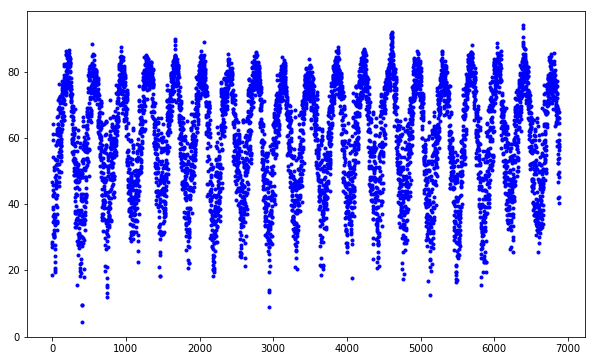

In [28]:
daily_temps.temp.plot(style='b.', figsize=(10,6), grid=False)

## Doing a bit of preprocessing due to presence of NaNs

In [29]:
nanLoc=np.where(np.isnan(daily_temps)==True)
daily_temps=daily_temps.drop(nanLoc[0],axis=0) #just drop the NAs

In [30]:
temp=daily_temps.pop('temp')
x=np.arange(0,len(temp),1)

A bit more visualization just to make sure that the removal of NaNs doesn't change the overall shape

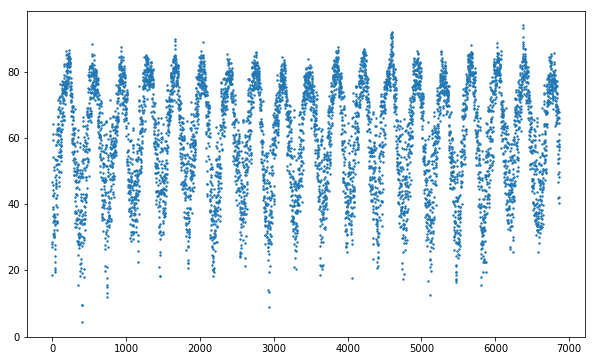

In [32]:
plt.figure(figsize=(10,6))
plt.scatter(x,temp,s=2)

In [13]:
#im making the assumption that these are linearly and consistently increasing day values, but the scatterplot seems to be the same 

From Section 5.1

Doing some formatting and reshaping so that we can put it into pymc3

In [71]:
temp_arr=np.array(temp)
x_arr=np.array(x)
temp_arr=temp_arr.reshape(len(temp_arr))
x_arr=x_arr.reshape(len(x_arr),1)

Initialize a sparse model using Matern52 and k-means inducing points because this dataset is too large to efficiently use a gaussian process

In [72]:
with pm.Model() as sparse_model:
    
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy('η', 5)
    
    cov =  (η**2 * pm.gp.cov.Matern52(1,ℓ))
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="FITC")

Set inducing points to make the process more efficient, in this I set the number of these points to 1/100th of the total sample space.

In [73]:
with sparse_model:
    
    Xu = pm.gp.util.kmeans_inducing_points(int(len(temp_arr)/100), x_arr)

Use a "maximum a posteriori" as another approximation to save computational/time resources  

In [74]:
with sparse_model:
    
    σ = pm.HalfCauchy("σ", beta=3)
    obs = gp.marginal_likelihood("obs", X=x_arr, Xu=Xu, y=temp_arr, noise=σ)

    marginal_post = pm.find_MAP()

/usr/people/chenb3/.conda/envs/bios8366/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -24,284, ||grad|| = 657: 100%|██████████| 41/41 [00:03<00:00, 13.11it/s]  


Make predictions using the sparse model using sample_ppc, X_new is another time saver as we are now computing fewer predictions as opposed to doing the full 7000+. This is done 10 times as per the prompt.

In [75]:
X_new = np.linspace(0,len(x_arr),int(len(temp_arr))/5)[:,None]

# add the GP conditional to the model, given the new X values
with sparse_model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with sparse_model:
    pred_samples = pm.sample_ppc([marginal_post], vars=[f_pred], samples=10)

/usr/people/chenb3/.conda/envs/pcreodeEnv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.
100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


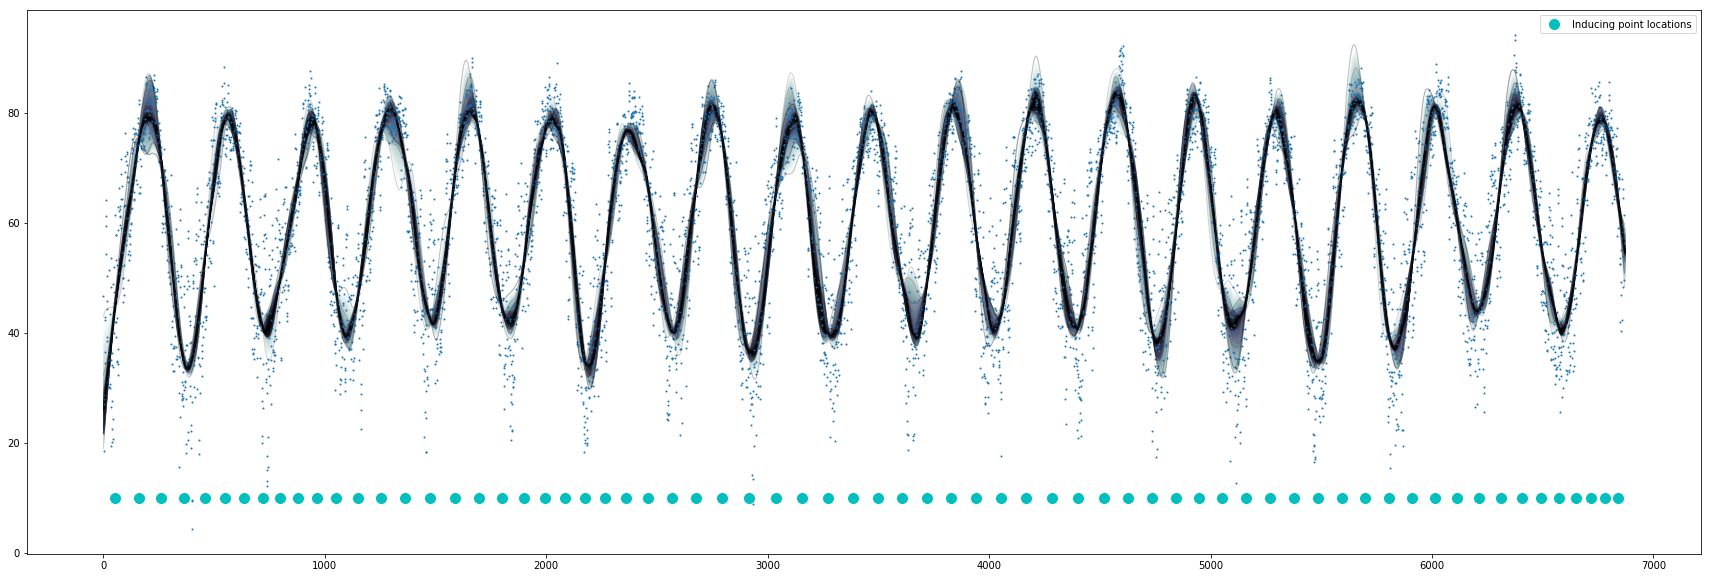

In [78]:
# plot the results
fig = plt.figure(figsize=(30,10)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["f_pred"], X_new,palette='bone_r') #the 10 
plt.scatter(x_arr,temp_arr,s=1)
plt.plot(Xu, 10*np.ones(Xu.shape[0]), "co", ms=10, label="Inducing point locations")
plt.legend()

## Question 3

Fit a series of random-forest classifiers to the Wisconsin breast cancer dataset (`wisconsin_breast_cancer.csv`), to explore the sensitivity to the parameters `max_features`, the number of variables considered for splitting at each step, `max_depth`, the maximum depth of the tree, and `n_estimators`, the number of trees in the forest. Use apprpriate metrics of performance, and include plots against a suitably-chosen range of values for these parameters.

Dataset description: Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. Ten real-valued features are computed for each cell nucleus:

- `radius` (mean of distances from center to points on the perimeter) 
- `texture` (standard deviation of gray-scale values) 
- `perimeter` 
- `area` 
- `smoothness` (local variation in radius lengths) 
- `compactness` (perimeter^2 / area - 1.0) 
- `concavity` (severity of concave portions of the contour) 
- `concave points` (number of concave portions of the contour) 
- `symmetry` 
- `fractal dimension` ("coastline approximation" - 1)

The outcome to be predicted is tumor type (M = malignant, B = benign).

First check what features there are in total

In [2]:
wis = pd.read_csv("~/Bios8366/data/wisconsin_breast_cancer.csv")
wis.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

Check to see if there are any NaNs

In [3]:
np.where(wis.isnull()) #no nans, we can probably just put this right into learning

(array([], dtype=int64), array([], dtype=int64))

In [4]:
wis.head()
#drop id, encode diagnosis, pop diagnosis

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Looks like we need to drop the ID because it's just not useful information. The diagnosis column has categorical values that need to be encoded and popped.

In [5]:
wis['outcome']=(wis.diagnosis=='M')
wis.outcome=wis.outcome.astype('int')
wis=wis.drop(['id','diagnosis'],axis=1)
y=wis.pop('outcome')

Setting up a training and testing set

In [6]:
X_train_wis, X_test_wis, y_train_wis, y_test_wis = model_selection.train_test_split(
        wis, y, test_size=0.2, random_state=0)
#split into training and testing sets

Initialize a parameter grid for a randomized search of hyperparameters

In [7]:
n_estimators = [6,7,8,9]
max_depth = [3,4,5,6]
max_features = [15,16,17,18,19,20]

# Create the random grid
parameter_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'max_features': max_features}

Initialize an RFC and set it to optimize for hyperparameters through GridSearchCV

In [8]:
rf = RandomForestClassifier(n_jobs=4, criterion='entropy') #default criterion
rf_cv = GridSearchCV(estimator=rf, param_grid=parameter_grid, n_jobs=4, verbose=3, cv=5)
rf_cv.fit(X_train_wis, y_train_wis)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   10.8s
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done 480 out of 480 | elapsed:   40.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [6, 7, 8, 9], 'max_depth': [3, 4, 5, 6], 'max_features': [15, 16, 17, 18, 19, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

Interestingly, the best_params_ seem to fluctuate a little bit upon rerunning, 'max_features' for example isn't always 20.

In [10]:
rf_cv.best_params_

{'max_depth': 4, 'max_features': 20, 'n_estimators': 7}

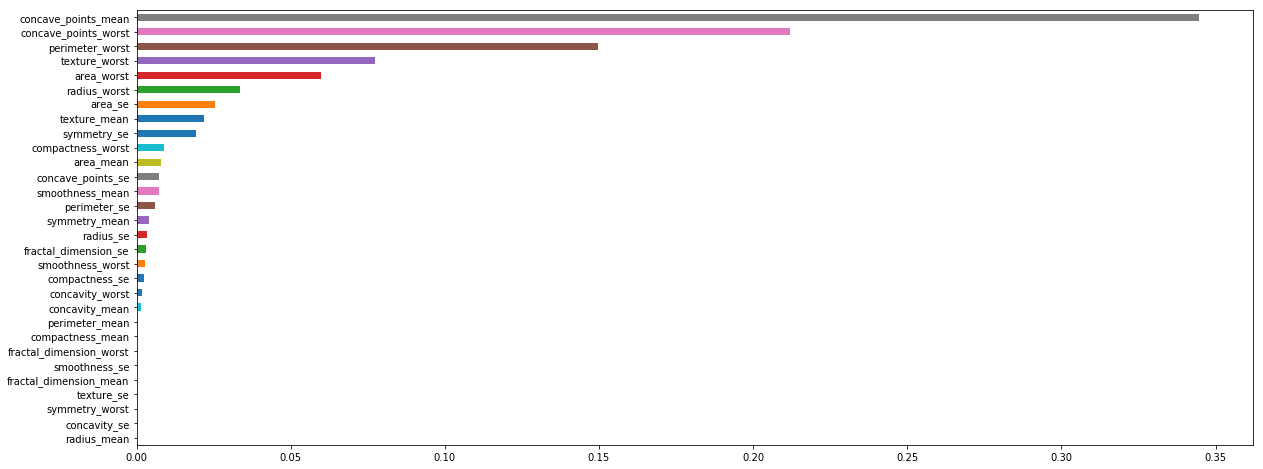

In [11]:
plt.figure(figsize=(20,8))
pd.Series(rf_cv.best_estimator_.feature_importances_, index=X_train_wis.columns).sort_values().plot.barh()

Looks like the concave_points are the mmost predictive features

Doing some predictions using these parameters on the test sets show promising results. 

In [110]:
preds_wis_depth=rf_cv.predict(X_test_wis)

In [111]:
rf_cv.score(X_test_wis, y_test_wis)

0.9649122807017544

In [112]:
explained_variance_score(preds_wis_depth, y_test_wis)

0.8551921244839631

In [113]:
confusion_matrix(y_test_wis, preds_wis_depth)

array([[65,  2],
       [ 2, 45]])

Further confirmation of the possibility of overfitting would involve altering the test_size parameter in the train/test splitting procedure.

## Question 4

Use a grid search to optimize the number of estimators and max_depth for a Gradient Boosted Decision tree using the Wisconsin breast cancer data. Plug this optimal ``max_depth`` into a *single* decision tree.  Does this single tree over-fit or under-fit the data? Repeat this for the Random Forest.  Construct a single decision tree using the ``max_depth`` which is optimal for the Random Forest.  Does this single tree over-fit or under-fit the data?

In [114]:
wis.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Setting up a parameter grid again, but this time for n_estimators and max_depth

In [24]:
n_estimators = [500,525,550,575,600]
max_depth = [1,2,3,4,5]

parameter_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

In [25]:
xgb = xgbc(learning_rate=0.02, objective='binary:logistic',
                    silent=True, nthread=4)
xgb_cv= GridSearchCV(estimator=xgb, param_grid=parameter_grid, scoring='roc_auc', n_jobs=4, verbose=3 )
xgb_cv.fit(X_train_wis,y_train_wis)

/usr/people/chenb3/.conda/envs/bios8366/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=4)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  68 out of  75 | elapsed:    2.6s remaining:    0.3s
[Parallel(n_jobs=4)]: Done  75 out of  75 | elapsed:    2.9s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_estimators': [500, 525, 550, 575, 600], 'max_depth': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [26]:
xgb_cv.best_params_

{'max_depth': 3, 'n_estimators': 575}

These best_params_ seem to pretty consistently land on 3 and 575.

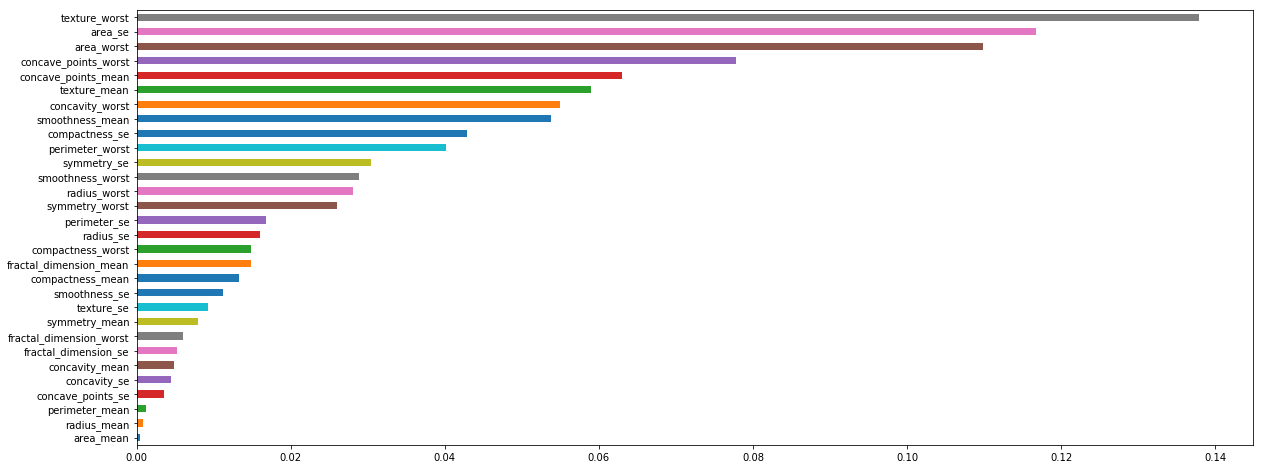

In [27]:
plt.figure(figsize=(20,8))
pd.Series(xgb_cv.best_estimator_.feature_importances_, index=X_train_wis.columns).sort_values().plot.barh()

Texture_worst, area_se, and area_worst seem to be the best predictors

In [28]:
preds_wis_depth = xgb_cv.predict(X_test_wis)

In [29]:
xgb_cv.score(X_test_wis, y_test_wis)

0.999047316608447

In [30]:
explained_variance_score(preds_wis_depth, y_test_wis)

0.8909846547314578

In [31]:
confusion_matrix(y_test_wis, preds_wis_depth)

array([[66,  1],
       [ 2, 45]])

The score and explained variance seem a bit too high, suggesting the possibility of overfitting.

## Try with single estimator/gradient boosted tree with the XGB_CV optimal depth of 3 

In [32]:
xgb = xgbc(learning_rate=0.02, objective='binary:logistic',
                    silent=True, nthread=4,n_estimators=1,max_depth=3)

In [33]:
xgb.fit(X_train_wis,y_train_wis)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [34]:
pred_wis_single=xgb.predict(X_test_wis)

In [35]:
xgb.score(X_test_wis,y_test_wis)

0.9649122807017544

In [36]:
explained_variance_score(pred_wis_single, y_test_wis)

0.8544283413848631

In [37]:
confusion_matrix(y_test_wis,pred_wis_single)

array([[66,  1],
       [ 3, 44]])

Still looks pretty good for a single tree, scores still seem pretty high up there. Probably overfit given that this was trained on 80% of the dataset. 

## Try with single estimator/random forest tree with the XGB_CV optimal depth of 3

In [38]:
rf = RandomForestClassifier(max_depth=3,criterion='entropy',n_jobs=4,verbose=3,n_estimators=1)

In [39]:
rf.fit(X_train_wis,y_train_wis)

building tree 1 of 1


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=4,
            oob_score=False, random_state=None, verbose=3,
            warm_start=False)

In [40]:
pred_wis_single_rf=rf.predict(X_test_wis)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [41]:
rf.score(X_test_wis,y_test_wis)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


0.9210526315789473

In [42]:
explained_variance_score(pred_wis_single_rf,y_test_wis)

0.6764520202020203

In [144]:
confusion_matrix(y_test_wis,pred_wis_single)

array([[66,  1],
       [ 3, 44]])

The score is decent but the explained variance is definitely not as good as a single gradient boosted tree. Perhaps this indicates less of a likelihood that the model was overfit with a single estimator.

## Try single estimator/gradient boosted tree with the RF_CV optimal depth of 4

In [43]:
xgb_rf_depth = xgbc(learning_rate=0.02, objective='binary:logistic',
                    silent=True, nthread=4,n_estimators=1,max_depth=4)

In [44]:
xgb_rf_depth.fit(X_train_wis,y_train_wis)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [45]:
pred_wis_xgb_rf_depth=xgb_rf_depth.predict(X_test_wis)

In [46]:
xgb_rf_depth.score(X_test_wis,y_test_wis)

0.956140350877193

In [47]:
explained_variance_score(pred_wis_xgb_rf_depth, y_test_wis)

0.8180946291560103

In [48]:
confusion_matrix(y_test_wis,pred_wis_xgb_rf_depth)

array([[65,  2],
       [ 3, 44]])

The optimal depth of the Crossvalidated Random Forest Classifier isn't all that different from XGBC so we seem to get results that are similar to what we saw previously with the depth of 3. Seems overfit with such high scores.